In [10]:
import pandas as pd

import importlib, csiro_biomass_shared_utils as csiro_su
importlib.reload(csiro_su)

import importlib, data_prep_helper as dph
importlib.reload(dph)

pd.set_option('display.expand_frame_repr', False)  # don't split into blocks
pd.set_option('display.width', 200)               # or None for auto / very wide
pd.set_option('display.max_columns', None)        # show all columns

In [11]:
import os

# List all attached datasets
print(os.listdir("/kaggle/input/csiro-biomass"))

['sample_submission.csv.0', 'sample_submission.csv', 'sample_submission.csv_ref', 'train.csv', 'test.csv', 'train_intermediate.csv', 'sample_submission.csv_bak', 'csiro-biomass.zip', 'test', 'train']


## Overall Data

In [12]:
import os, cv2
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(data_root, in_csv_fl):
    # ---------------------------------
    # Read the data from CSV
    train_df = pd.read_csv(f"{data_root}/{in_csv_fl}")
    # print(f"INPUT:\n{train_df}")

    cols_to_drop = ["State", "Sampling_Date", "image_path"]
    biomass_cols_order = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]
        
    train_df = train_df.drop(columns=cols_to_drop)
    # print(train_df)

    # Change the sample_id to have just ID and nothing else
    train_df["sample_id"] = train_df["sample_id"].str.split("__").str[0]

    train_pivot = (
        train_df.pivot_table(
            index=["sample_id", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"],
            columns="target_name",
            values="target"
        ).reset_index()
    )

    train_pivot = train_pivot.rename_axis(columns=None)

    # ensure biomass columns are in a fixed order
    train_pivot = train_pivot [
        ["sample_id", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"] + biomass_cols_order
    ]

    return train_pivot.reset_index(drop=True)

In [13]:
data_root = "/kaggle/input/csiro-biomass"
in_csv_fl="train.csv"

train_df = pd.read_csv(f"{data_root}/{in_csv_fl}")
print(train_df)

full_df = prepare_data(data_root=data_root, in_csv_fl=in_csv_fl)
print(full_df)

                       sample_id              image_path Sampling_Date State          Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target
0     ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000
1       ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984
2      ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751
3      ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735
4            ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750
...                          ...                     ...           ...   ...              ...            ...          

## 1) Clean + validate rows (before any split)

### 1.1 Remove impossible / inconsistent targets

In [14]:
summary, bad_rows = dph.check_biomass_nonnegative(full_df)
print(summary)
bad_rows.head(25)

{'n_rows': 357, 'n_bad': 0, 'pct_bad': 0.0}


,Dry_Dead_g,Dry_Green_g,Dry_Clover_g,Dry_Total_g,GDM_g


In [15]:
summary, bad_rows, out_df = dph.check_dry_total_sumlike(full_df)

print(summary)
bad_rows.head(25)   # show worst violations

{'n_rows': 357, 'n_pass': 302, 'n_fail': 55, 'pct_fail': 15.406162464985995, 'min_diff': -0.30879999999999974, 'median_diff': 0.0}


,Dry_Total_g,Dry_Green_g,Dry_Dead_g,Dry_Clover_g,parts_sum,diff
193,10.1912,3.0000,7.0000,0.5000,10.5000,-0.3088
92,108.2500,28.8667,11.4857,67.8977,108.2501,-0.0001
150,90.3042,1.0751,19.3509,69.8783,90.3043,-0.0001
108,107.4400,64.3724,7.9034,35.1643,107.4401,-0.0001
212,54.4000,34.6182,4.9455,14.8364,54.4001,-0.0001
163,43.0709,15.1546,21.9343,5.9821,43.0710,-0.0001
283,33.9000,7.8111,23.2770,2.8120,33.9001,-0.0001
222,30.1575,14.2453,15.6092,0.3031,30.1576,-0.0001
258,50.6000,39.3556,7.2286,4.0159,50.6001,-0.0001
259,42.0000,26.7273,7.6364,7.6364,42.0001,-0.0001


### What your check result actually says

Your output:

* `n_rows = 356`
* `n_pass = 301`
* `n_fail = 55` (`pct_fail ≈ 15.45%`)
* `median_diff = 0.0`
* many “fails” have `diff ≈ -0.0001` which is basically **floating/rounding noise**.
* the worst shown is about `diff ≈ -0.3088` (still small vs totals like ~10–100g).

So the conclusion is:
✅ **The sum-like relationship is mostly consistent**.
❌ The “fails” are **not big enough** to justify dropping targets.

### What to do instead (recommended)

1. **Keep predicting all 5 targets.**

2. **Use the sum-like constraint as a training helper**, not a reason to ignore targets:

   * Either add a small consistency penalty:

     * penalize `(Dry_Total_pred - (Green_pred + Dead_pred + Clover_pred))`
   * Or use “residual parameterization”:

     * predict `Green`, `Dead`, `Clover`, and a small `Total_residual`
     * then `Total = Green + Dead + Clover + Total_residual`
       This uses that relationship to *improve* `Dry_Total_g`, not replace the parts.

3. **Match your training loss weights to evaluation weights**:

* give more emphasis to `Dry_Total_g` (0.5) and `GDM_g` (0.2),
* but still train the three 0.1 targets (don’t drop them).


## 2) Handle heavy skew + outliers (your hist/boxplots scream this) (**TBD -- ON TRAINING DATA ONLY**)

### 2.1 Use `log1p` on *all five biomass targets*

NameError: name 'plt' is not defined

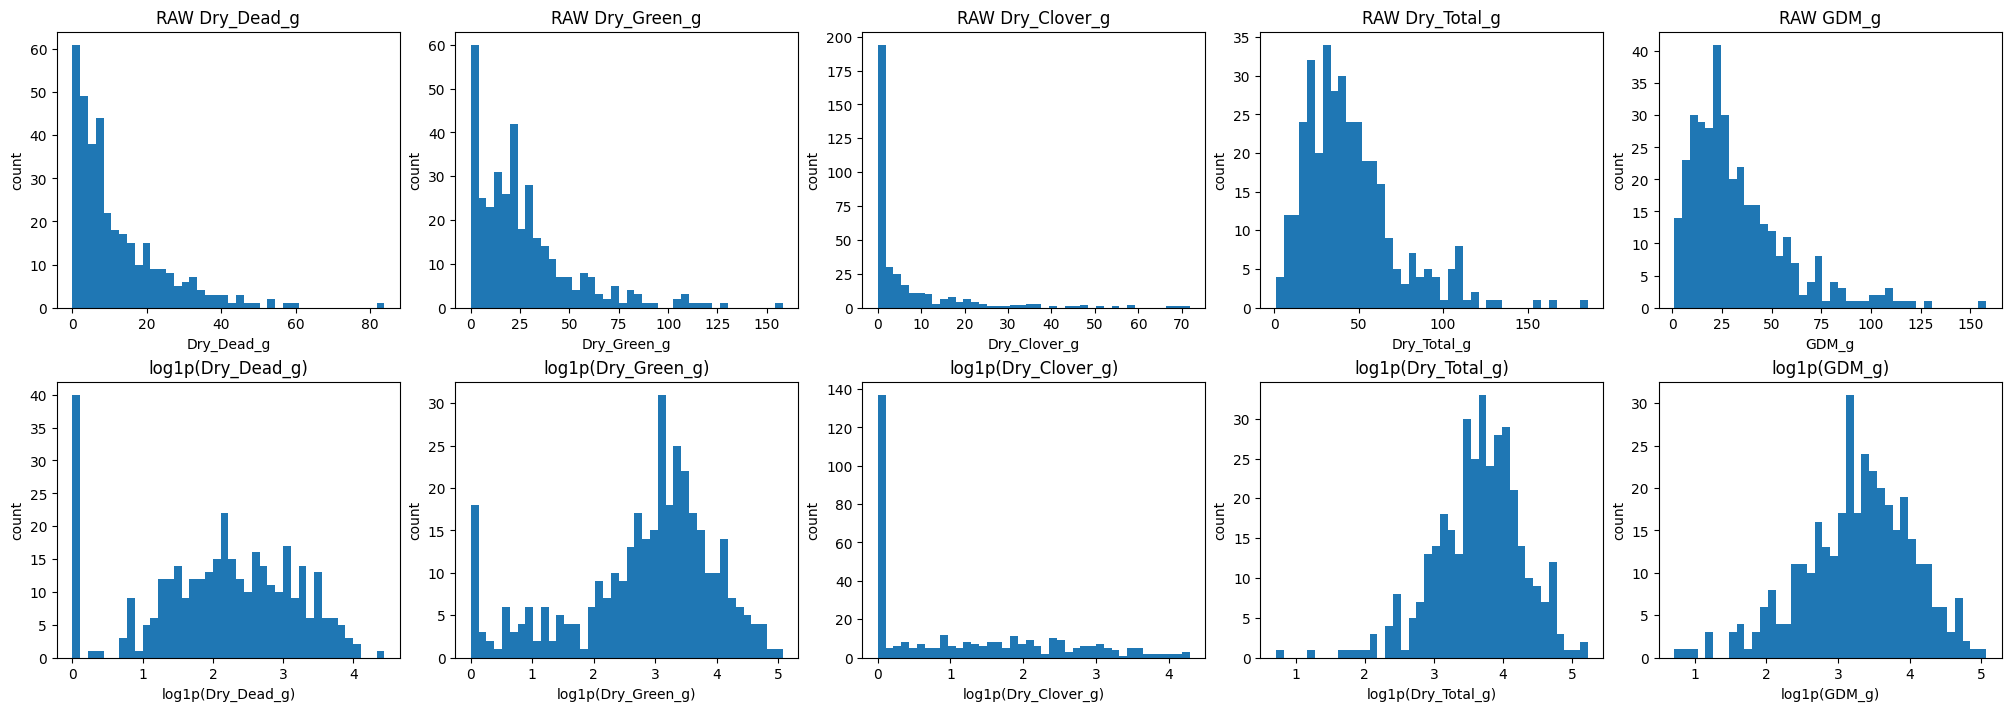

In [16]:

target_cols = ["Dry_Dead_g", "Dry_Green_g", "Dry_Clover_g", "Dry_Total_g", "GDM_g"]
dph.plot_targets_and_log1p(full_df, target_cols=target_cols, bins=40)
plt.show()


Here are the main takeaways that jump out from your **raw vs log1p** histograms:

* **All 5 raw targets are strongly right-skewed** (long tail to the right). Most samples sit at low grams, and a small number of samples are very large → raw-space MSE will get dominated by those few large values.

* **`Dry_Dead_g` has a big “near-zero pile-up”** in raw space (lots of values extremely close to 0) *plus* a long tail going out to ~80+.
  After `log1p`, you can clearly see a spike at `0` (exact zeros) and the remaining mass spreads nicely across roughly `~1 to ~4+`.

* **`Dry_Clover_g` is even more extreme**: massive concentration near 0 with a tail up to ~70+.
  Even after `log1p`, it stays “heavy at zero + spread-out tail” → this target is basically **zero-inflated** (many zeros, some positives).

* **`Dry_Green_g`, `Dry_Total_g`, `GDM_g` become much more “model-friendly” after `log1p`**:
  In raw, they’re skewed; in `log1p`, they look closer to a unimodal / bell-ish distribution (especially `Dry_Total_g` and `GDM_g`). This usually makes regression training more stable.

* **Zeros matter**: the `log1p` plots show a visible bar at `0` for multiple targets (particularly `Dry_Dead_g` and `Dry_Clover_g`).
  That tells you a decent fraction of the dataset is exactly 0 → your model must learn *both* “is it present?” and “if present, how much?”

* **Different targets have different tail severity**:
  `Dry_Total_g` and `GDM_g` have long tails too (out to ~180 and ~160), but compared to Clover/Dead they look less “all piled at zero” and more continuously spread.

If you want 2 “actionable” implications from these plots:

1. **Training in `log1p` space is the right move** for all five (your plots basically justify it visually).
2. For **`Dry_Clover_g` (and somewhat `Dry_Dead_g`)**, consider treating them as *zero-inflated regression* (presence/absence + amount), because the distribution shape is not just skew—it’s “many zeros + long tail.”


### 2.2 Winsorize (cap) extreme tail *before* computing normalization stats

In [ ]:
from dataclasses import dataclass
from typing import Dict, Optional
import numpy as np
import pandas as pd

@dataclass
class SplitConfig:
    strat_col: str = "Species"
    seed: int = 42

    # fractions must sum to 1.0
    train_frac: float = 0.70
    valid_frac: float = 0.15
    test_frac:  float = 0.15

    # Option B: group rare classes into "Other" ONLY for stratification
    group_rare_for_strat: bool = True
    rare_min_count: int = 10
    other_label: str = "Other"

class SpeciesStratifiedSplitter:
    def __init__(self, cfg: SplitConfig):
        assert abs((cfg.train_frac + cfg.valid_frac + cfg.test_frac) - 1.0) < 1e-9
        self.cfg = cfg

    def _make_strat_labels(self, df: pd.DataFrame) -> pd.Series:
        s = df[self.cfg.strat_col].astype(str).fillna("NA")
        if not self.cfg.group_rare_for_strat:
            return s

        vc = s.value_counts()
        rare_species = vc[vc < self.cfg.rare_min_count].index
        strat = s.where(~s.isin(rare_species), self.cfg.other_label)
        return strat

    def split(self, df: pd.DataFrame) -> Dict[str, np.ndarray]:
        """
        Returns positional indices (use with df.iloc[idx]).
        """
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except ImportError as e:
            raise ImportError("Please `pip install scikit-learn` (sklearn) to use stratified splitting.") from e

        rng = np.random.RandomState(self.cfg.seed)
        n = len(df)
        all_idx = np.arange(n)

        strat_labels = self._make_strat_labels(df)

        # 1) train vs temp
        sss1 = StratifiedShuffleSplit(
            n_splits=1,
            test_size=(1.0 - self.cfg.train_frac),
            random_state=rng.randint(0, 2**31 - 1),
        )
        train_idx, temp_idx = next(sss1.split(all_idx, strat_labels))

        # 2) temp -> valid vs test (keep original valid:test ratio)
        temp_labels = strat_labels.iloc[temp_idx].reset_index(drop=True)
        valid_ratio_within_temp = self.cfg.valid_frac / (self.cfg.valid_frac + self.cfg.test_frac)

        sss2 = StratifiedShuffleSplit(
            n_splits=1,
            test_size=(1.0 - valid_ratio_within_temp),
            random_state=rng.randint(0, 2**31 - 1),
        )
        # note: split operates on positions within temp
        temp_pos = np.arange(len(temp_idx))
        valid_pos, test_pos = next(sss2.split(temp_pos, temp_labels))

        valid_idx = temp_idx[valid_pos]
        test_idx  = temp_idx[test_pos]

        return {
            "train": np.array(train_idx, dtype=np.int64),
            "valid": np.array(valid_idx, dtype=np.int64),
            "test":  np.array(test_idx,  dtype=np.int64),
        }

    @staticmethod
    def save_splits(path: str, splits: Dict[str, np.ndarray]) -> None:
        # saves as a single .npz file
        np.savez(path, **{k: v.astype(np.int64) for k, v in splits.items()})

    @staticmethod
    def load_splits(path: str) -> Dict[str, np.ndarray]:
        z = np.load(path)
        return {k: z[k].astype(np.int64) for k in z.files}

def print_species_distribution(df: pd.DataFrame, idx: np.ndarray, col: str = "Species", name: str = ""):
    s = df.iloc[idx][col].astype(str).fillna("NA")
    vc = s.value_counts()
    pct = (vc / vc.sum() * 100.0).round(2)
    out = pd.DataFrame({"count": vc, "pct": pct})
    print(f"\n== {name} (n={len(idx)}) ==")
    print(out)

# ---------------- USAGE ----------------
df = full_df.copy()

cfg = SplitConfig(
    strat_col="Species",
    seed=42,
    train_frac=0.70,
    valid_frac=0.15,
    test_frac=0.15,
    group_rare_for_strat=True,  # Option B behavior (recommended if many very rare species)
    rare_min_count=10,
    other_label="Other",
)

splitter = SpeciesStratifiedSplitter(cfg)
splits = splitter.split(df)

sanity_df = dph.species_distribution_table(df, splits, species_col="Species", include_full=True)
display(sanity_df)   # in notebook
# print(sanity_df.to_string())

# save indices (so split is reproducible + reusable)
SpeciesStratifiedSplitter.save_splits("splits_seed42.npz", splits)

# later:
splits = SpeciesStratifiedSplitter.load_splits("splits_seed42.npz")
train_df = df.iloc[splits["train"]]
valid_df = df.iloc[splits["valid"]]
test_df  = df.iloc[splits["test"]]


,full_count,full_pct,train_count,train_pct,valid_count,valid_pct,test_count,test_pct
Species,,,,,,,,
Ryegrass_Clover,98,27.45,68,27.31,15,27.78,15,27.78
Ryegrass,62,17.37,43,17.27,9,16.67,10,18.52
Phalaris_Clover,42,11.76,29,11.65,6,11.11,7,12.96
Clover,41,11.48,29,11.65,6,11.11,6,11.11
Fescue,28,7.84,20,8.03,4,7.41,4,7.41
Lucerne,22,6.16,15,6.02,4,7.41,3,5.56
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed,11,3.08,8,3.21,2,3.70,1,1.85
Fescue_CrumbWeed,10,2.80,7,2.81,2,3.70,1,1.85
WhiteClover,10,2.80,7,2.81,1,1.85,2,3.70


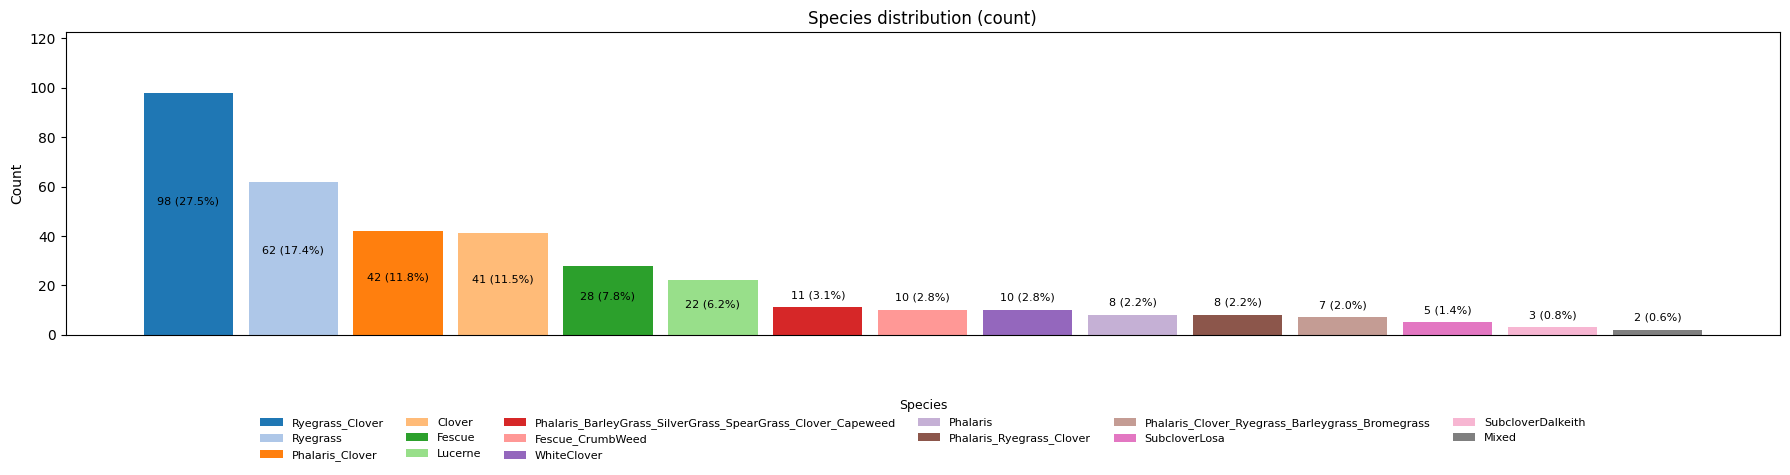

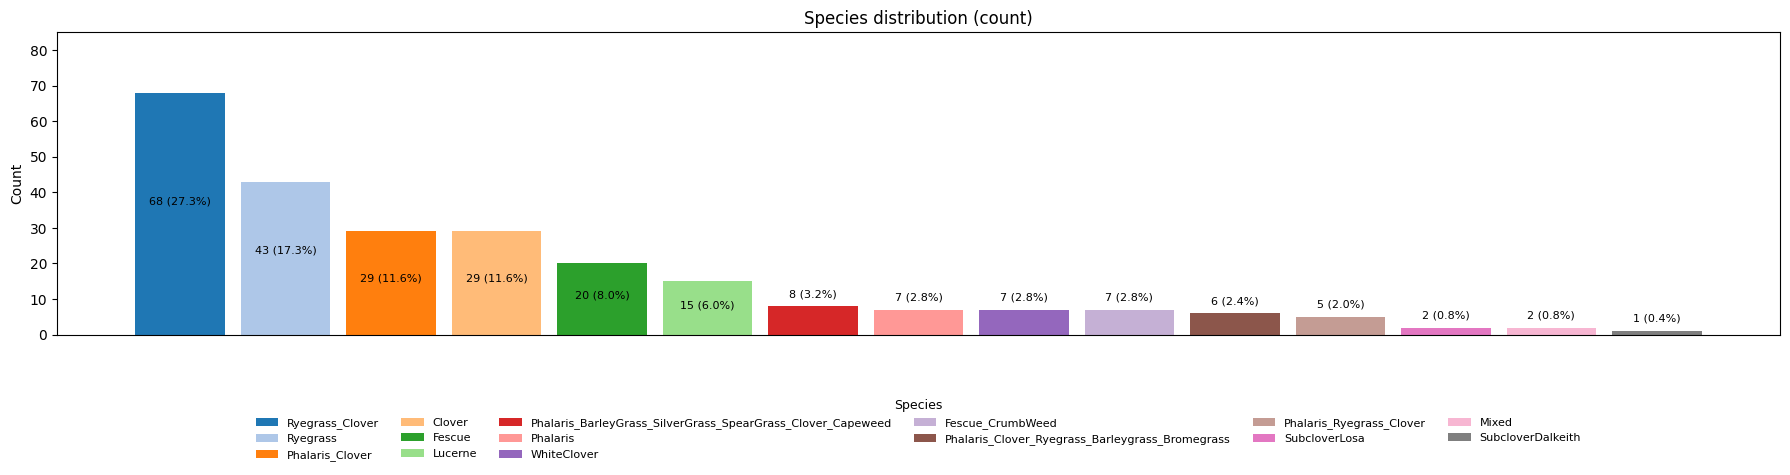

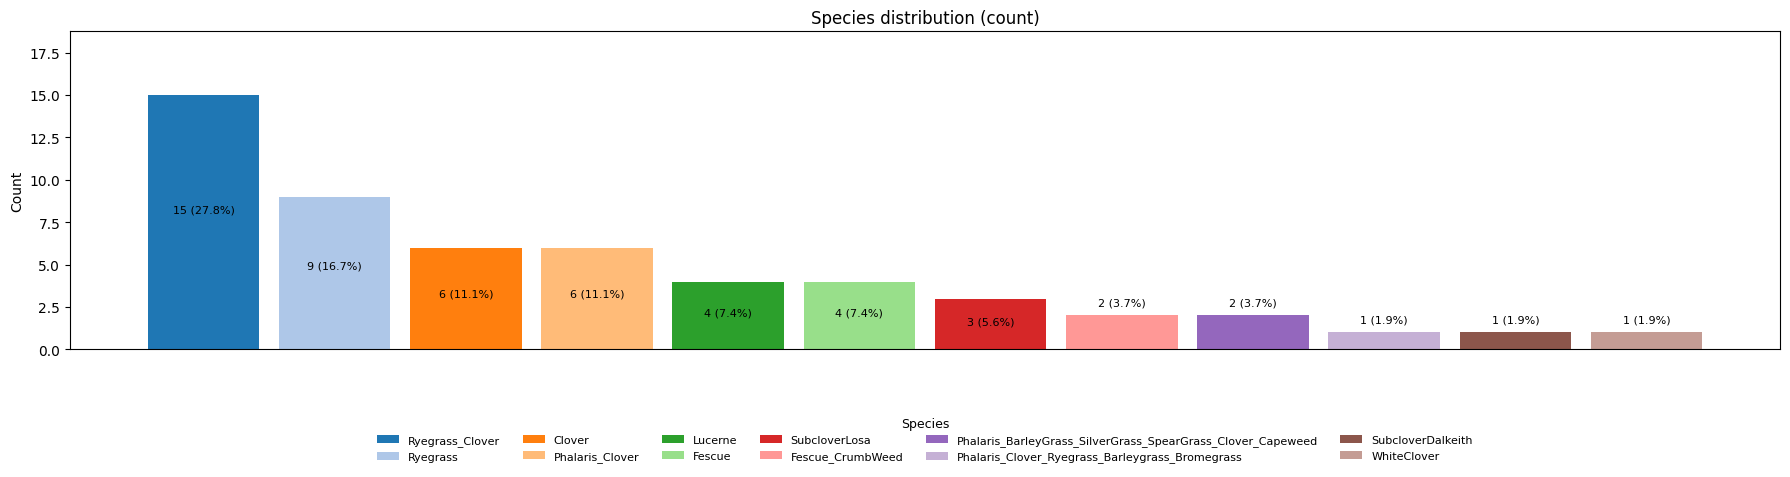

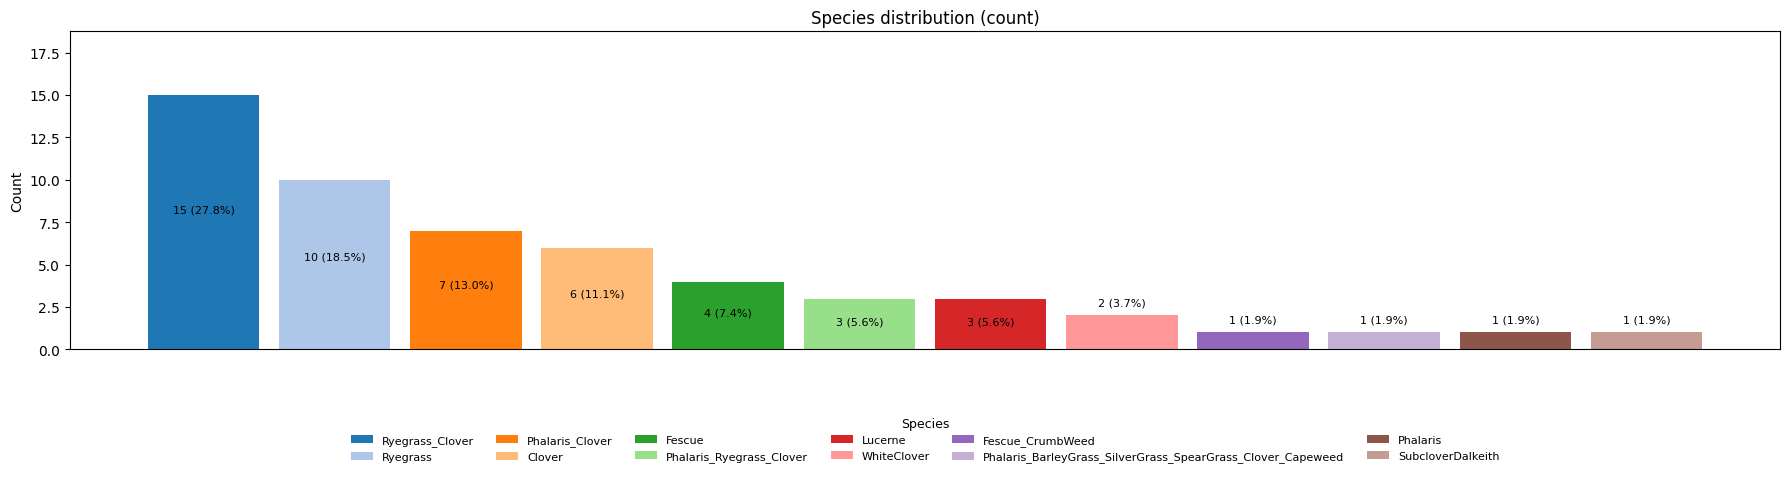

In [ ]:
# usage
counts, pct = csiro_su.species_distribution_count(full_df)
counts, pct = csiro_su.species_distribution_count(train_df)
counts, pct = csiro_su.species_distribution_count(valid_df)
counts, pct = csiro_su.species_distribution_count(test_df)